<a href="https://colab.research.google.com/github/mcalmeida13/Coursera_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - Japanese Restaurants in São Paulo

---


### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [About São Paulo](#sp)
* [Business Problem](#business)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction

## About São Paulo

São Paulo is the biggest city in Brazil. As all metropolis around the world, it has a long history of international immigration and it is home to nearly 12.2 million people in 2018, accounting for over 27% of the population of São Paulo State.

The city continues to be the leading metropolitan gateway for legal immigrants admitted into Brazil.

São Paulo is known for its strong Asian culture, not only the one that came with Japanese immigrants but also Korean, Chinese, and many others.

In 1908, the Japanese began to immigrate to Brazil, becoming the place with the highest number of Japanese people outside Japan. The Brazilian census agency calculated in 2017 there were around 1.5 million Japanese descendants living in Brazil.

For many years, the Japanese culture was concentrated in São Paulo, in a neighborhood called 'Liberdade' ('Freedom' in Portuguese). There, the majority of the shops sell Asian related products. 

Nowadays, Japanese cooking is a Brazilian passion, and it gained lots of local adaptations.

## Business Problem

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Japanese restaurant** in **São Paulo, Brazil**.

Since there are lots of japanese restaurants in São Paulo we will try to detect **locations that are already crowded with japanese restaurants** and **locations that are not already crowded with japanese restaurants**. We are also particularly interested in **areas with no Japanese restaurants in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## 3. Data Collection

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Japanese restaurants in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:

São Paulo's information about neighborhoods and boroughs will be obtained from the data source: https://en.wikipedia.org/wiki/List_of_postal_codes_in_Brazil

All data related to locations and quality of Japanese restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## 4. Methodology

* Data fom São Paulo will be collected, cleaned and processed into a dataframe.
*  FourSquare be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
* Data will be sorted based on rankings.
*  Finally, the data will be visually assessed using graphing from Python libraries.


### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Liberdade, São Paulo's Neighborhood.


In [46]:
%matplotlib inline
import pandas as pd # library for data analsysis
import numpy as np
from bs4 import BeautifulSoup # library for pulling data out of HTML and XML files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>foursquare_agent</em>, as shown below.

In [2]:
CLIENT_ID = 'K1PZL4VGIDCPSFOVFCIGIT4ARIHQE4SFZO1F1BYUA2XXU0RL' # your Foursquare ID
CLIENT_SECRET = 'EJTRPC20QXKD25FOOXWMRDAUV2BLKSQND1ZII5ARD5UP1241' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K1PZL4VGIDCPSFOVFCIGIT4ARIHQE4SFZO1F1BYUA2XXU0RL
CLIENT_SECRET:EJTRPC20QXKD25FOOXWMRDAUV2BLKSQND1ZII5ARD5UP1241


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# São Paulo Data

In [4]:
# Upload the Wikipedia page
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_in_Brazil#S%C3%A3o_Paulo').text
soup = BeautifulSoup(source,'lxml')

#extract all the <li> tags into a list
tags = soup.find_all('li')

table = []
# identify tags
for tag in tags:
        table.append(tag.text)


df = pd.DataFrame(table, columns = ['City'])
sp = df[df['City'].str.contains('São Paulo')]
sp.head()


,City
1,2 By states and parts\n\n2.1 Acre\n2.2 Alagoas...
74,2.24 São Paulo\n\n2.24.1 01000s\n2.24.2 02000s...
98,01000-000 to 09999-999 - São Paulo Metropolita...
99,11000-000 to 19999-999 - State of São Paulo
689,01000-xxx - São Paulo


## Cleaning Data

In [5]:
sp = sp[5:]
cep = sp['City'].apply(lambda x: x.split('-')[0])
bairro = sp['City'].apply(lambda x: x.split('-')[-1])
sp['Cep'] = cep
sp['Região'] = bairro
sp.head()

,City,Cep,Região
690,01010-xxx - São Paulo,01010,São Paulo
691,01060-xxx - São Paulo,01060,São Paulo
692,01070-xxx - São Paulo,01070,São Paulo
693,01080-xxx - São Paulo,01080,São Paulo
694,01090-xxx - São Paulo,01090,São Paulo


In [6]:
teste = sp['Região'].apply(lambda x: x.split('(')[0])
teste2 = sp['Região'].apply(lambda x: x.split('(')[-1])
sp['Região'] = teste
sp['Bairro'] = teste2
teste4 = sp['Bairro'].apply(lambda x: x.replace(')',''))
sp['Bairro'] = teste4
sp.tail()

,City,Cep,Região,Bairro
751,05508-xxx - University of São Paulo,05508,University of São Paulo,University of São Paulo
752,05600-xxx - São Paulo (Morumbi),05600,São Paulo,Morumbi
753,05700-xxx - São Paulo (Campo Limpo),05700,São Paulo,Campo Limpo
754,05800-xxx - São Paulo (Capão Redondo),05800,São Paulo,Capão Redondo
772,08383-xxx - São Paulo (3ª Divisão),08383,São Paulo,3ª Divisão


In [7]:
sp.drop(['City'],axis=1, inplace=True)
sp.head()

,Cep,Região,Bairro
690,01010,São Paulo,São Paulo
691,01060,São Paulo,São Paulo
692,01070,São Paulo,São Paulo
693,01080,São Paulo,São Paulo
694,01090,São Paulo,São Paulo


In [8]:
teste5 = sp['Bairro'].apply(lambda x: x.replace(' São Paulo','São Paulo'))
sp['Bairro'] = teste5
sp['Bairro'].str.contains('University')
sp.drop(index=751, inplace=True)

In [9]:
sp_df = pd.DataFrame({"PostalCode": sp['Cep'],
                           "Borough": sp['Região'],
                           "Neighborhood": sp['Bairro']})

sp_df.head()

,PostalCode,Borough,Neighborhood
690,01010,São Paulo,São Paulo
691,01060,São Paulo,São Paulo
692,01070,São Paulo,São Paulo
693,01080,São Paulo,São Paulo
694,01090,São Paulo,São Paulo


In [10]:
bairros_sp = ['São Paulo',
 'Bom Retiro',
 'Vila Buarque',
 'Largo do Arouche',
 'Consolação',
 'Jardins',
 'Liberdade',
 'Santana',
 'Vila Maria',
 'Jaçanã',
 'Tremembé',
 'Mandaqui',
 'Casa Verde',
 'Cachoeirinha',
 'Limão',
 'Brasilândia',
 'Freguesia do Ó',
 'Brás',
 'Mooca',
 'Vila Alpina',
 'Tatuapé',
 'Aricanduva',
 'Vila Matilde',
 'Penha',
 'Cangaíba',
 'Ermelino Matarazzo',
 'Sapopemba',
 'Vila Mariana',
 'Santa Cruz',
 'Ipiranga',
 'Jabaquara',
 'Cidade Ademar',
 'Itaim Bibi',
 'Campo Belo',
 'São Paulo Airport',
 'Santo Amaro',
 'Cidade Dutra',
 'Guarapiranga',
 'Barra Funda',
 'Pirituba',
 'Perus',
 'Jaguaré',
 'Pinheiros',
 'Butantã',
 'Morumbi',
 'Campo Limpo',
 'Capão Redondo',
 '3ª Divisão']
len(bairros_sp)

48

In [11]:
list1 = []
list2 = []
for bairro in bairros_sp:
  address = bairro + ', São Paulo, BR'
  geolocator = Nominatim(user_agent="ny_explorer")
  location = geolocator.geocode(address)
  latitude = location.latitude
  longitude = location.longitude
  list1.append(latitude)
  list2.append(longitude)

In [16]:
bairros = pd.DataFrame(columns =['Neighborhood,Latitude,Longitude'])
bairros['Neighborhood'] = bairros_sp
bairros['Latitude'] = list1
bairros['Longitude'] = list2
bairros.drop('Neighborhood,Latitude,Longitude',axis=1, inplace=True)
bairros.head()


,Neighborhood,Latitude,Longitude
0,São Paulo,-23.550651,-46.633382
1,Bom Retiro,-23.527138,-46.636835
2,Vila Buarque,-23.544562,-46.647552
3,Largo do Arouche,-23.541626,-46.646265
4,Consolação,-23.557818,-46.660537


In [18]:
sp_df_new = sp_df.merge(bairros, on="Neighborhood", how="left")
sp_df_new

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,01010,São Paulo,São Paulo,-23.550651,-46.633382
1,01060,São Paulo,São Paulo,-23.550651,-46.633382
2,01070,São Paulo,São Paulo,-23.550651,-46.633382
3,01080,São Paulo,São Paulo,-23.550651,-46.633382
4,01090,São Paulo,São Paulo,-23.550651,-46.633382
...,...,...,...,...,...
58,05500,São Paulo,Butantã,-23.569131,-46.721874
59,05600,São Paulo,Morumbi,-23.596499,-46.717845
60,05700,São Paulo,Campo Limpo,-23.632558,-46.759666
61,05800,São Paulo,Capão Redondo,-23.671903,-46.779435


In [26]:
sp_df_new.dropna(inplace=True)

#Visualizing the Neighborhoods

In [27]:
address = 'Liberdade, São Paulo, BR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Liberdade are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Liberdade are -23.566703500000003, -46.63180928373991.


In [28]:
# create map of Toronto using latitude and longitude values
map_sp = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng in zip(sp_df_new.Latitude,sp_df_new.Longitude):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

## Let's analyze further and see how many Japanese restaurants there are in each neighborhood and borough. After it, graph the results.

In [39]:
ny_data = sp_df_new[['Borough', 'Neighborhood','Latitude','Longitude']]

In [59]:
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 2 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 3 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 4 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 5 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 6 / 57 ) Japanese Restaurants in Bom Retiro,  São Paulo :0
[' São Paulo ', 'Bom Retiro', -23.5271385, -46.636834846501365]
( 7 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 8 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo', -23.5506507, -46.6333824]
( 9 / 57 ) Japanese Restaurants in São Paulo,  São Paulo:2
[' São Paulo', 'São Paulo

In [60]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') 

In [78]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
50,50,São Paulo,Campo Belo,54bee7ec498ed474b9b329c1,Tsuyoi Sushi Bar
51,51,São Paulo,Santo Amaro,531f2e6f498e97c0b46dd9b7,Takô
52,52,São Paulo,Santo Amaro,55269a43498ecaf17df513a9,Yujin Temaki & Cia
53,53,São Paulo,Pinheiros,5a589ec71fa7635837a38170,Itsu Restaurante
54,54,São Paulo,Pinheiros,4d08e07c9232236a9d4bc053,Kaminari Sushi


In [62]:
japanese_rest_ny.shape

(55, 4)

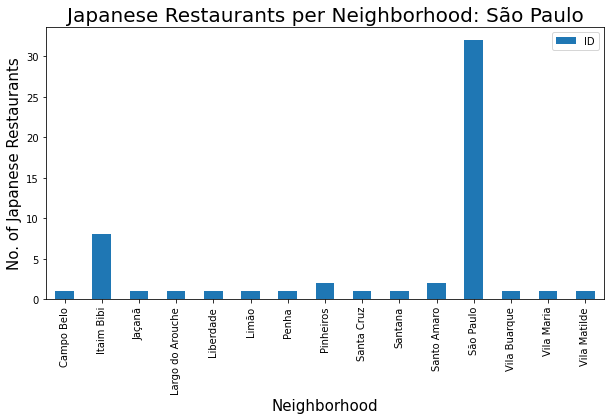

In [63]:
japanese_rest_ny.groupby('Neighborhood')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Japanese Restaurants per Neighborhood: São Paulo', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

We have a problem with our data, because majority have neighborood 'São Paulo'. Let's drop this values

In [64]:
japanese_clean = japanese_rest_ny[japanese_rest_ny['Neighborhood'] != 'São Paulo']

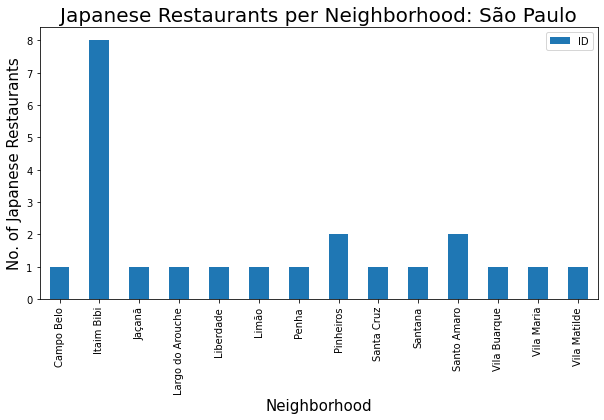

In [65]:
japanese_clean.groupby('Neighborhood')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Japanese Restaurants per Neighborhood: São Paulo', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

In [66]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Liberdade']

,Borough,Neighborhood,ID,Name
30,São Paulo,Liberdade,5d55e8a3a69e870007d12703,Nawaki Sushi


In [67]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Itaim Bibi']

,Borough,Neighborhood,ID,Name
42,São Paulo,Itaim Bibi,4e375379fa7606f143fa99c8,OHKA
43,São Paulo,Itaim Bibi,50b8af34e4b01367264841f2,Nakka
44,São Paulo,Itaim Bibi,57c997e9498e5f2030c47638,Tatá Sushi
45,São Paulo,Itaim Bibi,4e172e8118388d0d26866aa2,Kibo Sushi
46,São Paulo,Itaim Bibi,5a385f046fa81f01a587c37b,Magô
47,São Paulo,Itaim Bibi,50b15551e4b099c54ae15145,Kappa Sushi Bar
48,São Paulo,Itaim Bibi,4b6ec721f964a52030ca2ce3,Kosushi
49,São Paulo,Itaim Bibi,57c87d94498e289da513bbf9,Ryo Gastronomia


So the Itaim Bibi has the highest number of Japanese Restaurants with a total count of 8.

# Business Analysis

Areas with the tradition of the same kind of restaurants can be a two-edged sword. In these areas, people already expect to find those kinds of restaurants. Therefore, marketing is automatic. On the other side, competition is fierce.

Places with little or no tradition with this kind of restaurant can be an excellent place to start because there is no competition. But maybe the neighborhood is not used for the type of food.

In our analysis, the majority of restaurants are in Itaim Bibi. But I think it is underreported. I believe a more in-depth analysis should be done. Liberdade is a well know place with Japanese culture, and the search returned only one restaurant. 

In São Paulo, I believe any place is an excellent place to open a Japanese restaurant. The population loves this kind of food. But I think in the nearby areas of Liberdade Neighborhood would be the best place.



# Conclusion

The purpose of this project was to identify São Paulo areas close to center with low restaurants (particularly Japanese restaurants) to aid stakeholders in narrowing down the search for the optimal location for a new Japanese restaurant. By calculating restaurant density distribution from Foursquare data, we first identified general boroughs that justify further analysis (Liberdade) and then generated an extensive collection of locations that satisfy some basic requirements regarding existing nearby restaurants. The clustering of those locations was then performed to create significant zones of interest (containing the most significant number of potential areas). The addresses of those zone centers were designed to be used as starting points for final exploration by stakeholders.

The final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and places in every recommended zone. I am considering factors like the attractiveness of each position (proximity to Liberdade neighborhood), levels of noise/proximity to major roads, real estate availability, prices, social and economic dynamics of every area.